<img src="../Images/DSC_Logo.png" style="width: 400px;">

# Temperature Anomalies

![sky](../Images/temperature.jpg)

*Image modified from Gerd Altmann, Pixabay*

This notebook analyzes a dataset of global temperature anomalies for months from 1850 to 2024 against the 1901-2000 average. The data serves as a critical resource for assessing long-term climate trends and variations over time. It is sourced from the NOAA National Centers for Environmental Information. The dataset is used to demonstrate outliers and data gaps in time series, to analyze stationarity, autocorrelation, and patterns in time series and to calculate linear trends.


**Original dataset:** NOAA National Centers for Environmental information: Climate at a Glance: Global Time Series [Data set]. https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/global/time-series, retrieved on August 23, 2024.

In [1]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) # Suppress specific warnings

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## **Exercise 1: Time Series Basics**

## 1. Load, Prepare and Plot Time Series Data

**Exercise:** Import the dataset of NOAA global temperature anomalies in **monthly resolution**. The path of the dataset is '../Datasets/NOAA_time_series_monthly.csv'.

In [4]:
path = '../Datasets/NOAA_time_series_monthly.csv' 
global_temp = pd.read_csv(path, skiprows=4, delimiter=',')

**Exercise:** Print the first rows of the dataset to see it's structure.

In [ ]:
global_temp.head()

**Exercise:** convert *Date* into a `datetime` object, set the date column as index for easy analysis and and check the datasets' structure after conversion.

In [ ]:
global_temp['Date'] = pd.to_datetime(global_temp['Date'].astype(str), format='%Y%m')
global_temp.set_index('Date', inplace=True) # Set the 'Date' column as the index
global_temp.head()

**Exercise:** Print summary statistics of the time series.

In [ ]:
global_temp.describe()

**Exercise:** Plot the time series.

In [ ]:
global_temp.plot()

**Exercise:** In addition, create a bar plot showing median monthly anomalies.

In [ ]:
# Add column holding month
global_temp['month'] = global_temp.index.month

# Calculate the average anomaly per month
average_anomalies = global_temp.groupby('month')['Anomaly'].median()

# Create a bar plot using matplotlib
plt.figure()
average_anomalies.plot(kind='bar', color='skyblue')
plt.title('Average Anomalies by Month')
plt.xlabel('Month')
plt.ylabel('Average Anomaly')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## **Exercise 2: Exploration of Time Series Features**

## 2. Time Series Decomposition and Evaluation

Investigating the time series features of global temperature anomalies is essential for understanding the Earth's climate dynamics. Analyzing trends allows us to identify long-term warming patterns. Examining seasonal patterns helps differentiate natural climatic variations from anthropogenic influences. Additionally, studying the residuals, or the remaining values after removing trends and seasonality, helps uncover and study any anomalies or outliers.

**Exercise:** Decompose the time series into the components trend, seasonal, and residual using an additive model from the `statsmodels` library. Are the patterns as you expected?

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

temp_decompose = seasonal_decompose(global_temp['Anomaly'], model='additive')
temp_decompose.plot()
plt.title('Seasonal Decomposition of Temperature Anomalies')
plt.show()

**Exercise:** Does the decomposition effectively captured the underlying structure of the time series, accurately separating the trend and seasonal components from the random fluctuations? Plot the ACF (using the `statsmodels` library) with 48 lags to check for any remaining autocorrelation in the residuals. Eventually test different lag sizes to see the difference in information you gain from the ACF plot. In addition, plot the lag plot from the `pandas` library. 

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf

# Extract residuals and drop NaN values
temp_resid = temp_decompose.resid.dropna()

# Plot ACF of the residuals for 48 lags
plot_acf(temp_resid, lags=48)
plt.title('ACF of Residuals')
plt.show() 

In [ ]:
from pandas.plotting import lag_plot

lag_plot(temp_resid)
plt.title('Lag Plot of the Time Series')
plt.tight_layout()
plt.show()

While the ACF plot shows some autocorrelation in the residuals, the random scatter in the lag plot indicates that the residuals are uncorrelated. Additional analysis are needed.

**Exercise:** Conducting a white noise test like the Ljung-Box test would provide additional confidence that the residuals are uncorrelated and the decomposition effectively captured the time series structure. Calculate the Ljung-Box statistics using the `statsmodels` library.

In [ ]:
from statsmodels.tsa.stattools import acf

# Calculating ACF, Ljung-Box statistics, and p-values
r, q, p = acf(temp_resid, nlags=35, qstat=True)
print('ACF values:', r) 
print('Ljung-Box statistics:', q)
print('P-values:', p)

The Ljung-Box test does not support the hypothesis that the residuals are white noise. Instead, it indicates that the decomposition could be improved, as the residuals still exhibit autocorrelation. Although the ACF plot shows mostly small autocorrelations beyond lag 1, the Ljung-Box test's extremely small p-values provide strong statistical evidence that some structure or correlation remains in the residuals.

**Exercise:** Further assess the stationarity of residuals for validating the decomposition process by examining their rolling mean and standard deviation. Use a rolling window size of 12 months. The choice of a 12-month window allows for capturing annual trends and seasonal variations. Plot these statistics alongside the residuals to evaluate their stationarity visually.

In [ ]:
# Rolling mean and standard deviation of the residuals
rolm = temp_resid.rolling(window=12, center=True).mean()
rolstd = temp_resid.rolling(window=12, center=True).std()

# Plot residuals, rolling mean, and rolling std
plt.plot(temp_resid, label='Decomposed Residuals')
plt.plot(rolm, label='Rolling Mean', linestyle='--')
plt.plot(rolstd, label='Rolling Std', linestyle=':', c='red')
plt.title('Residuals of Temperature Anomalies')
plt.legend()
plt.show()

The residuals appear mostly stationary based on the rolling mean and standard deviation.

**Exercise:** Explore seasonality using the `month_plot` from the `statsmodels` library. This plot can be used to check for any recurring patterns or trends across different months over several years.

In [ ]:
from statsmodels.graphics.tsaplots import month_plot

# Generate seasonal plots
month_plot(global_temp['Anomaly'])
plt.title('Monthly Temperature Anomalies Seasonal Plot')
plt.show()

## **Exercise 3: Time Series Model ARIMA**

## 3. Investigate the Time Series for Stationarity and Differencing

**Exercise:** Do you expect that the temperature anomaly time series is stationary? Calculate the `kpss` statistics to test it.

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf
from pandas.plotting import lag_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm

In [8]:
global_temp

,Date,Anomaly
0,185001,-0.46
1,185002,-0.21
2,185003,-0.22
3,185004,-0.36
4,185005,-0.30
...,...,...
2091,202404,1.29
2092,202405,1.18
2093,202406,1.22
2094,202407,1.22


In [11]:
from statsmodels.tsa.stattools import kpss

# KPSS test for stationarity
kpss_stat, p_value, lags, crit_values = kpss(global_temp['Anomaly'], regression='c', nlags='auto')

# Output the results of the KPSS test
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Lags: {lags}')
print('Critical Values:', crit_values)
if p_value < 0.05:
    print("The series is likely non-stationary.")
else:
    print("The series is likely stationary.")

KPSS Statistic: 5.303529068527813
p-value: 0.01
Lags: 28
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is likely non-stationary.


/tmp/ipykernel_1899/3225542127.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(global_temp['Anomaly'], regression='c', nlags='auto')


**Exercise:** Conduct differencing the time series with a lag of 1 and plot the resulting time series.

**Exercise:** Plot the ACF and PACF plots of the differenced time series and calculate the KPSS statistics to check again for stationarity.

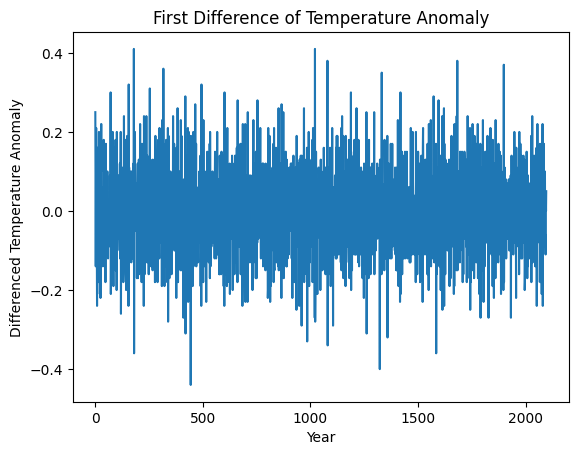

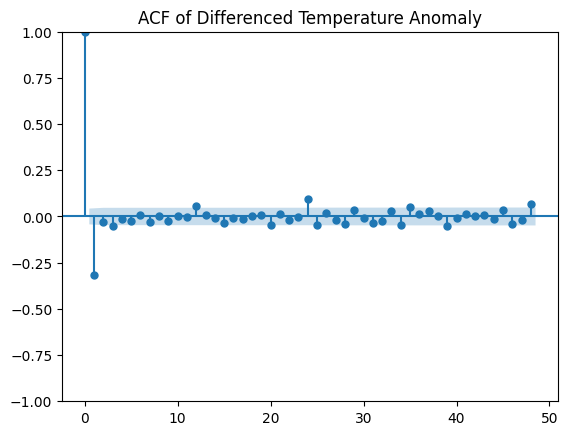

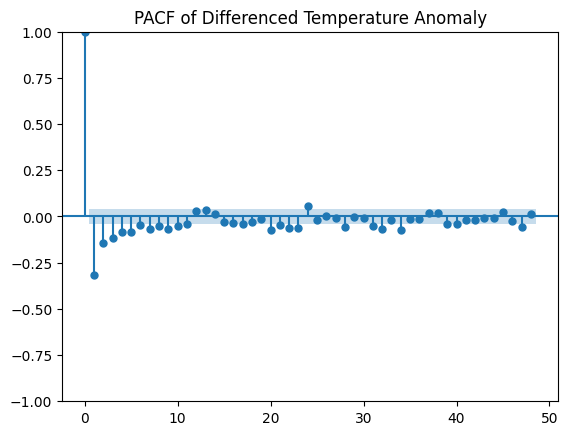

KPSS Statistic: 0.14231953158230717
p-value: 0.1
Lags: 69
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
The series is likely stationary.


/tmp/ipykernel_1899/832534267.py:20: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_stat, p_value, lags, crit_values = kpss(dt, regression='c', nlags='auto')


In [15]:
dt = global_temp['Anomaly'].diff(1).dropna()

# Plot the differenced series
dt.plot()
plt.title('First Difference of Temperature Anomaly')
plt.xlabel('Year')
plt.ylabel('Differenced Temperature Anomaly')
plt.show()

# Plot ACF using PythonTsa (PACF is not plotted here)
plot_acf(dt, lags=48)
plt.title('ACF of Differenced Temperature Anomaly')
plt.show()

plot_pacf(dt, lags=48)
plt.title('PACF of Differenced Temperature Anomaly')
plt.show()

# KPSS test for stationarity
kpss_stat, p_value, lags, crit_values = kpss(dt, regression='c', nlags='auto')

# Output the results of the KPSS test
print(f'KPSS Statistic: {kpss_stat}')
print(f'p-value: {p_value}')
print(f'Lags: {lags}')
print('Critical Values:', crit_values)
if p_value < 0.05:
    print("The series is likely non-stationary.")
else:
    print("The series is likely stationary.")

## 4. ARIMA

In [16]:
from statsmodels.tsa.arima.model import ARIMA 

def choose_model(x, max_p, max_q, ctrl=1.03):
    best_aic = np.inf
    best_order = None
    best_mdl = None

    for p in range(max_p + 1):
        for q in range(max_q + 1):
            try:
                if p == 0 and q == 0:
                    continue
                # Use ARIMA model instead of ARMA
                model = ARIMA(x, order=(p, 0, q))
                results = model.fit()
                aic = results.aic
                if aic < best_aic:
                    best_aic = aic
                    best_order = (p, q)
                    best_mdl = results
            except Exception as e:
                print(f"Model fitting failed for order ({p},{q}) with error: {e}")
                continue

    print(f"Best ARIMA model order: {best_order} with AIC: {best_aic}")
    return best_mdl

**Exercise:** Use the 'choose_model' function to identify the best ARIMA model for the time series. Explore a range of autoregressive (p) and moving average (q) parameters. Analyze the output to assess the most suitable ARIMA model parameters for the temperature anomalies.

Note: Running the loop to find the best ARIMA model with the temperature anomalies time series can take a considerable amount of time because of it's length. Therefore choose a rather small range of parameters (e.g. 0 to 3).

### Choosing model

In [17]:
max_p = 3
max_q = 3
model_metrics = []

print("Fitting ARMA models...")  # Debug message

for p in range(max_p + 1):
    for q in range(max_q + 1):
        if p == 0 and q == 0:
            continue  # Skip the case where both p and q are zero
        
        try:
            model = ARIMA(global_temp['Anomaly'], order=(p, 0, q)).fit()  # Use ARIMA with d=0 for ARMA
            model_metrics.append((p, q, model.aic, model.bic, model.hqic))  # Store p, q, AIC, BIC, HQIC
            print(f"Fitted ARIMA({p}, 0, {q}) with AIC: {model.aic}, BIC: {model.bic}, HQIC: {model.hqic}")  # Print AIC, BIC, HQIC for each fitted model
        except Exception as e:
            print(f"Error fitting ARIMA({p}, 0, {q}): {e}")

# Convert model metrics to DataFrame for easier analysis
metrics_df = pd.DataFrame(model_metrics, columns=['p', 'q', 'AIC', 'BIC', 'HQIC'])

# Print model metrics
print("\nModel Metrics for Different ARMA Models:")
print(metrics_df)

# Get the best model based on the minimum AIC
if not metrics_df.empty:
    best_model = metrics_df.loc[metrics_df['AIC'].idxmin()]
    print("\nBest ARMA Model (p, q, AIC, BIC, HQIC):", best_model)
else:
    print("No models were fitted successfully.")

Fitting ARMA models...
Fitted ARIMA(0, 0, 1) with AIC: -101.12132261300701, BIC: -84.17796447668421, HQIC: -94.91482541224032
Fitted ARIMA(0, 0, 2) with AIC: -1200.8374834641752, BIC: -1178.2463392824116, HQIC: -1192.5621538631528
Fitted ARIMA(0, 0, 3) with AIC: -1823.4002892055755, BIC: -1795.1613589783708, HQIC: -1813.0561272042976
Fitted ARIMA(1, 0, 0) with AIC: -3412.3537466756766, BIC: -3395.410388539354, HQIC: -3406.14724947491
Fitted ARIMA(1, 0, 1) with AIC: -3672.011927263421, BIC: -3649.420783081657, HQIC: -3663.7365976623987
Fitted ARIMA(1, 0, 2) with AIC: -3691.2718843427565, BIC: -3663.032954115552, HQIC: -3680.927722341479
Fitted ARIMA(1, 0, 3) with AIC: -3710.1517629140644, BIC: -3676.265046641419, HQIC: -3697.738768512531
Fitted ARIMA(2, 0, 0) with AIC: -3608.981848890855, BIC: -3586.390704709091, HQIC: -3600.7065192898326


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(2, 0, 1) with AIC: -3709.7163589640313, BIC: -3681.477428736827, HQIC: -3699.3721969627536


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(2, 0, 2) with AIC: -3741.6444966468985, BIC: -3707.757780374253, HQIC: -3729.231502245365


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(2, 0, 3) with AIC: -3741.454460766249, BIC: -3701.9199584481626, HQIC: -3726.9726339644603
Fitted ARIMA(3, 0, 0) with AIC: -3643.8951009380717, BIC: -3615.656170710867, HQIC: -3633.550938936794


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(3, 0, 1) with AIC: -3734.151481741726, BIC: -3700.2647654690804, HQIC: -3721.7384873401925


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(3, 0, 2) with AIC: -3713.697947428961, BIC: -3674.1634451108744, HQIC: -3699.216120627172


/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted ARIMA(3, 0, 3) with AIC: -3735.926713134952, BIC: -3690.7444247714247, HQIC: -3719.3760539329073

Model Metrics for Different ARMA Models:
    p  q          AIC          BIC         HQIC
0   0  1  -101.121323   -84.177964   -94.914825
1   0  2 -1200.837483 -1178.246339 -1192.562154
2   0  3 -1823.400289 -1795.161359 -1813.056127
3   1  0 -3412.353747 -3395.410389 -3406.147249
4   1  1 -3672.011927 -3649.420783 -3663.736598
5   1  2 -3691.271884 -3663.032954 -3680.927722
6   1  3 -3710.151763 -3676.265047 -3697.738769
7   2  0 -3608.981849 -3586.390705 -3600.706519
8   2  1 -3709.716359 -3681.477429 -3699.372197
9   2  2 -3741.644497 -3707.757780 -3729.231502
10  2  3 -3741.454461 -3701.919958 -3726.972634
11  3  0 -3643.895101 -3615.656171 -3633.550939
12  3  1 -3734.151482 -3700.264765 -3721.738487
13  3  2 -3713.697947 -3674.163445 -3699.216121
14  3  3 -3735.926713 -3690.744425 -3719.376054

Best ARMA Model (p, q, AIC, BIC, HQIC): p          2.000000
q          2.000000
AIC  

**Exercise:** Based on your previous model selection process, specify the optimal ARIMA model parameters and utilize the ARIMA function to fit the model to the differenced temperature anomalies, applying the selected parameters.

**Exercise:** Analyze whether the ARIMA model fits the data well. Ideally, we want to see that the residuals resemble white noise, implying that you have captured all systematic patterns in the data. Analyze the residuals from the ARIMA model using with the following: ACF, Lag plot, Ljung-Box statistics, Q-Q plot and normality test.

/opt/conda/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


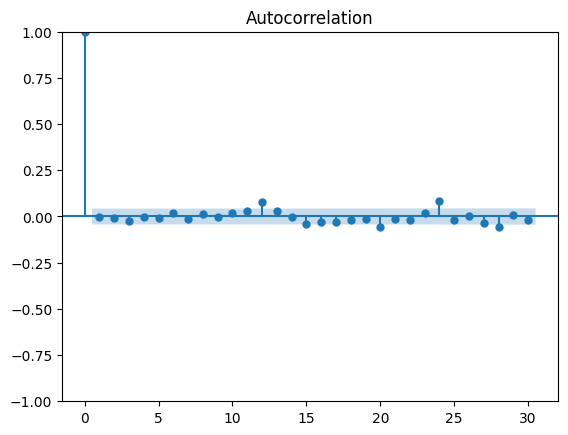

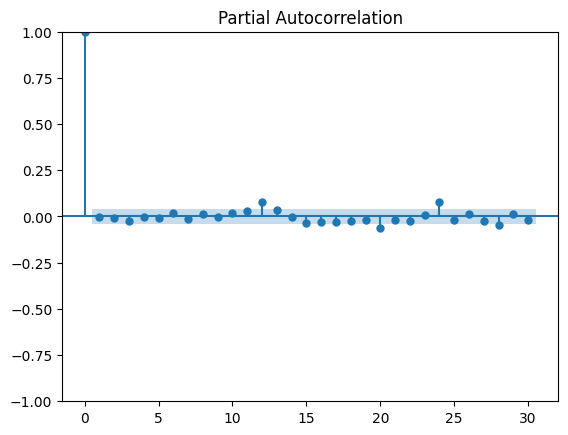

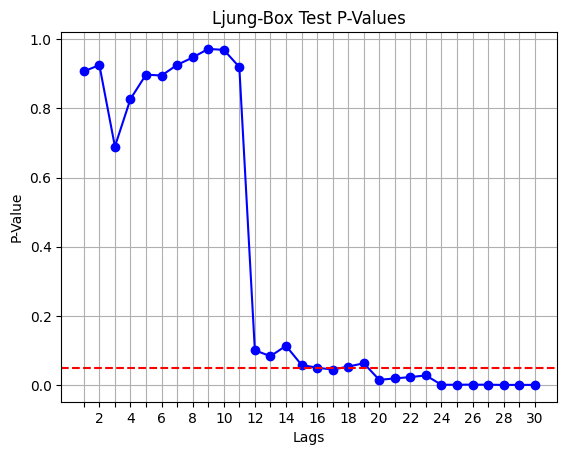

Normality test result: NormaltestResult(statistic=np.float64(27.98544651435145), pvalue=np.float64(8.376016083730912e-07))


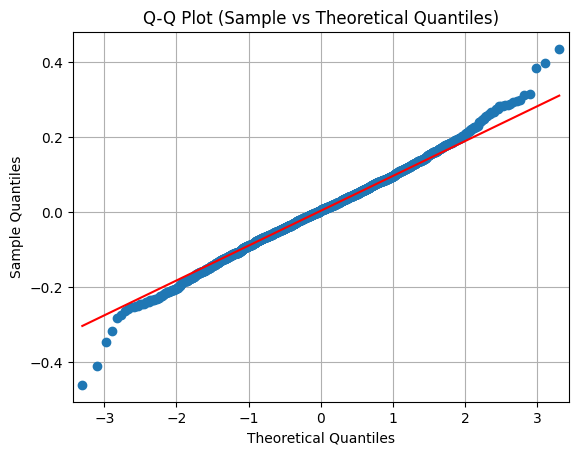

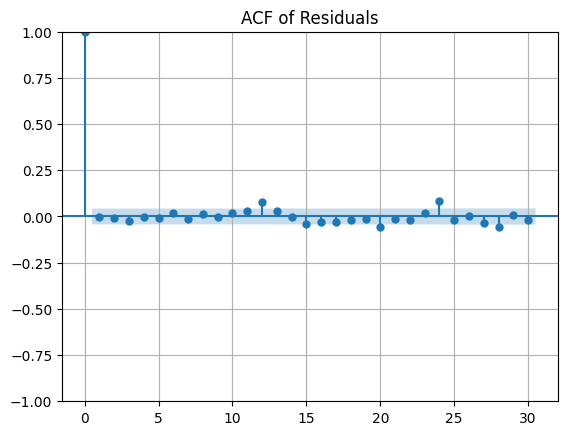

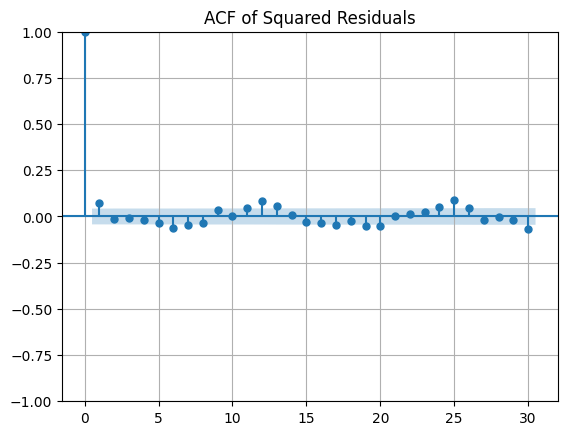

In [21]:
# Fit the ARMA(2, 2) model
arma22 = ARIMA(global_temp['Anomaly'], order=(2, 0, 2), trend='n').fit()

# Analyze the residuals
resid22 = arma22.resid

# Plot ACF and PACF of the residuals
plot_acf(resid22, lags=30)
plt.show()
plot_pacf(resid22, lags=30)
plt.show()

# Perform the Ljung-Box test for residuals
    # Calculate Ljung-Box test statistics and p-values
ljung_box_results = acorr_ljungbox(resid22, lags=30, return_df=True)
    # Create a plot for the p-values
plt.figure()
plt.plot(ljung_box_results['lb_pvalue'], marker='o', linestyle='-', color='b')
plt.axhline(y=0.05, color='r', linestyle='--')  # 5% significance level
plt.title('Ljung-Box Test P-Values')
plt.xlabel('Lags')
plt.ylabel('P-Value')
plt.xticks(np.arange(0, 31, 1))
plt.xticks(ljung_box_results.index)  # Set x-ticks to all lags
plt.gca().set_xticklabels([str(int(x)) if x % 2 == 0 else '' for x in ljung_box_results.index])
plt.grid()
plt.show()

# Perform the normality test on residuals
from scipy import stats 
normaltest_result = stats.normaltest(resid22)
print("Normality test result:", normaltest_result)

# Q-Q plot
plt.figure()
sm.qqplot(resid22, line='q', ax=plt.gca())
plt.title('Q-Q Plot (Sample vs Theoretical Quantiles)')
plt.grid()

# ACF of Residuals
plt.figure()
plot_acf(resid22, lags=30, ax=plt.gca())  # ACF plot for residuals
plt.title('ACF of Residuals')
plt.grid()

# ACF of Squared Residuals
plt.figure()
plot_acf(np.square(resid22), lags=30, ax=plt.gca())  # ACF plot for squared residuals
plt.title('ACF of Squared Residuals')
plt.grid()

**Exercise:** Nevertheless, use the fitted ARMA model to predict temperature anomalies for the period from January 2000 to December 2025 to get a feeling for the workflow.